두 집단 평균 비교시: t검정
세 집단 이상에서 평균 비교시: f 검정 (=분산분석)
- if 두 집단에서 분산분석 비교 = 독립표본 t 검정


statsmodels랑 pingouin 라이브러리는 사후검정 제공 o
scipy는 사후검정 제공 x


[1] scipy 패키지의 일원분산분석 방법

f_oneway 특징: 추가적인 변수를 계속해서 넣을 수 있음
등분산성 -> 만족: one-way-Anova
        -> x: Welch-Anova

[2] statsmodels 패키지의 일원분산분석 방법

melt 처리 필요

C(store): category is store
residual: 잔차
F: F-통계량 (t-test의 등분산성 조건 충족 시 나오는 결괏값 s(t-통계량), p 중 s 값과 같은 기능)
PR(>F): p-value

sum_sq랑 mean_sq는 계산과정 보여주는 거니까 신경 안써도 되고
F랑 PR(>F)가 중요한 값임

[3] pingouin 패키지의 일원분산분석 방법

얘도 melt 처리 필요

# [LAB-10] 8. 일원분산분석 (One-way ANOVA)
목표: 코드 작성 과정을 이해하기 위해 두 집단 간 차이를 볼 예정

- 3개 이의 집단 간 평균의 차이를 검증하기 위해 사용
- 1. 가정(정규성, 등분산성) 확인
- 2. 분산분석(f-test) 종류:
  - 일원분산분석: ≥3개 집단간 평균차를 `단순 비교`
  - 이원분산분석: `~에 따른` ≥3개 집단간 평균차 비교
- 3. 사후검정 수행 가능 (분산분석 후)
  - 사후검정: 평균차가 구체적으로 어떤 수준(들)에서 나는지의 검정
  - (전제: 분산분석 결과가 통계적으로 유의하다는 결론을 얻음)

## #01. 준비작업

### 1. 패키지 참조:

`pingouin` 패키지 설치 필요

In [1]:
from hossam import load_data
from pandas import melt, DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt

# 가정 확인을 위한 라이브러리: `f_oneway`
from scipy.stats import t, f_oneway, ttest_ind, normaltest, bartlett, levene

# 일원분산분석용 라이브러리:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import anova
from pingouin import welch_anova

# 사후검정용 라이브러리:
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell

### 2. 그래프 초기화:

In [2]:
my_dpi = 200  # 이미지 선명도 (100~300)
font_path = r"\Users\itwill\OneDrive\문서\학원수업\NotoSansKR-Regular.ttf"  # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)      # 폰트 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname = font_path)    # 폰트 속성을 읽어옴
font_name = font_prop.get_name()    # 읽어온 속성에서 폰트의 이름만 추출

plt.rcParams['font.family'] = font_name # 그래프에 한글폰트 적용
plt.rcParams['font.size'] = 6          # 기본 폰트 크기
plt.rcParams['axes.unicode_minus'] = False  
    # 그래프에 마이너스 깨짐 방지 (한글 환경에선 필수)

### 3. 데이터 가져오기:

데이터셋 설명: 
- 동일한 제품을 판매중인 서로다른 두 지역의 매장, 100일간 일별 매출액 기록한 가상데이터
- 이 데이터를 사용해서 두 매장의 평균 비교하셈
- (10-7 예제에서 다뤘던 데이터임.)
  - 세 집단 간 차를 비교하기 위해 사용해야 하지만, 여기서는 분석 과정을 익히기 위해 두 집단간 차이를 비교할 예정임
  - 두 집단간 차이 비교를 위해 분산분석 할 시, t-test 결과는 차이 없을거임

In [3]:
origin = load_data('two_store')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 갯수: {origin.shape[1]}")
print(f"행 갯수: {origin.shape[0]}")

print("\n===== 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab10_/two_store.xlsx
[desc] 동일한 제품을 판매하고 있는 서로 다른 두 지역의 매장의 100일간의 일별 매출액을 기록한 가상의 데이터 (출처: 방송통신대학교 통계학개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (100, 2)
열 갯수: 2
행 갯수: 100

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   store1  100 non-null    int64
 1   store2  100 non-null    int64
dtypes: int64(2)
memory usage: 1.7 KB
None


,store1,store2
0,34,63
1,63,85
2,57,75
3,50,48
4,37,58


## #02. 데이터 분포, 가정 확인

### 1. 데이터 분포 화긴:

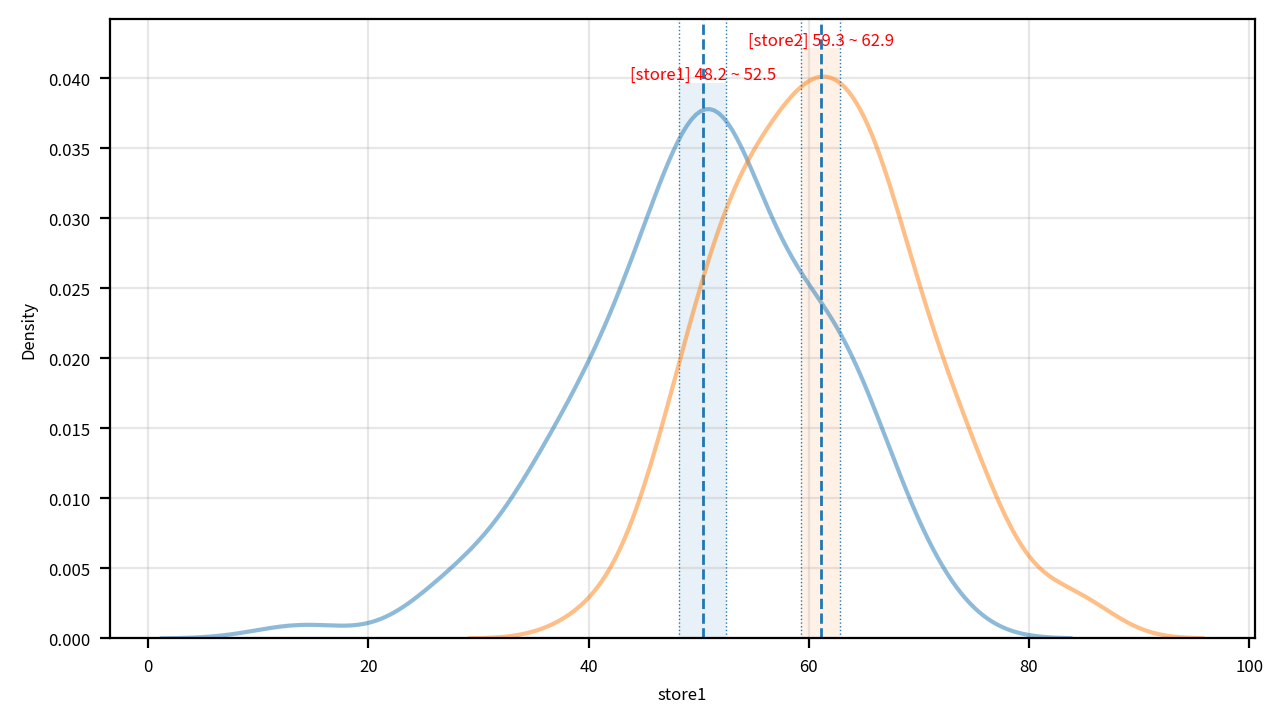

In [4]:
data = origin[['store1', 'store2']]  # 확인할 데이터 (컬럼단위)

# 1) 그래프 초기화 (초기설정, 캔버스(fig)랑 도화지(ax) 준비하기)
width_px = 1280             # 그래프 가로 크기
height_px = 720             # 그래프 세로 크기
rows = 1                    # 그래프 행 수
cols = 1                    # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

for c in data.columns:
    # 2) KDE plot 그리기:
    sb.kdeplot(data=data, x=c, fill=False, alpha=0.5)

    # 2-1) 신뢰구간용 기본변수:
    max = data[c].max()                        # 최대값
    dof = len(data[c]) - 1                     # 자유도
    clevel = 0.95                           # 신뢰수준
    sp_mean = data[c].mean()                   # 표본평균
    sp_std = data[c].std() # default: ddof=1   # 표본표준편차
    sp_std_error = sp_std / sqrt(len(data[c])) # 표본표준오차

    # 2-2) 신뢰구간 x값:
    cmin, cmax = t.interval(clevel, dof, loc = sp_mean, scale = sp_std_error)

    ax.axvline(cmin, linestyle=":", linewidth=0.5) # cmin 경계선
    ax.axvline(cmax, linestyle=":", linewidth=0.5) # cmax 경계선

    # 2-3) 신뢰구간 y값:
    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)

    # 2-4) 평균선 표시:
    ax.axvline(sp_mean, linestyle="--", linewidth=1)

    # 2-5) 텍스트 그리기 (statAnnotator 기능):
    ax.text(x = cmin + (cmax-cmin)/2,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
            horizontalalignment = "center",
            verticalalignment = "bottom",
            fontdict = {"size": 6, "color": "red"})

# 3) 그래프 꾸미기: 
ax.grid(True, alpha=0.3)     # 배경, 격자 표시/숨김

# 4) 출력
plt.tight_layout()           # 여백 제거
plt.show()                   # 그래프 화면 출력
plt.close()                  # 그래프 작업 종료

### 2. 가정(정규성) 검정:

In [5]:
data = origin[['store1', 'store2']]

equal_var_fields = []
normal_dist = True
report = []

for c in data.columns:
    s, p = normaltest(data[c])

    normalize = p > 0.05
    report.append({
        "fields": c,
        "statistic": s,
        "p-value": p,
        "result": normalize
    })
    normal_dist = normal_dist and normalize

# 변수가 두개 이상일 때 확인해야될 등분산성:
if len(data.columns) > 1:
    # 정규성 충족할 때 등분산성 검정방법:
    if normal_dist:
        n = "Bartlett"
        s, p = bartlett(*data.values.T) # 모든 컬럼의 데이터 한번에
    # 정규성 충족 못할 때 등분산성 검정법:
    else:
        n = "Levene's"
        s, p = levene(*data.values.T, center='median')
        # : 정규성 충족 못할 땐 '기본값인 평균'으로 계산하면 안됨
    
    report.append({
        "fields": n,
        "statistic": s,
        "p-value": p,
        "result": p > 0.05
    })

report_df = DataFrame(report).set_index('fields')
report_df

,statistic,p-value,result
fields,,,
store1,5.651229,0.059272,True
store2,1.173772,0.556056,True
Bartlett,3.143307,0.076239,True


-> 가설검정의 가정 검사결과: 정규성of store1, 정규성of store2, 등분산성 btw store 1 and 2 다 만족!

## #03. '일원분산분석' 수행

일원분산분석 방법 3 가지 (어떤 방법이든 결과는 동일):
- 방법 1: scipy 패키지의 `f_oneway()` 함수 사용
- 방법 2: statsmodels 패키지의 `anova_lm()` 함수 사용
- 방법 3: pinguoin 패키지의 `anova()` 함수 사용

| 구분 | 수식 | 내용 | 
| --- | ------- | ----- |
| 그룹1의 평균 | $\mu(store1)$ |
| 그룹2의 평균 | $\mu(store2)$ |
| 귀무가설($H_0$) | $\mu(store1)$ = $\mu(store2)$ | 두 매장 간 평균매출은 차이가 '없다'. |
| 대립가설($H_1$) | $\mu(store1)$ ≠ $\mu(store2)$ | 두 매장 간 평균매출은 차이가 '있다'. |

### 1. `scipy` 패키지 사용방법:

- 분산분석을 수행할 변수를 파라미터로 전달
- if 등분산성 만족 x: `equal_var=False` 파라미터 설정해서 Welsh_Anova로 전환 ㄱㄱ

In [6]:
# f-test (일원분산분석, scipy 패키지 사용 시)
s, p = f_oneway(origin['store1'], origin['store2'])
# if 등분산성 만족 x: 
# `equal_var=False` 파라미터 설정해서 Welsh_Anova로 전환 ㄱㄱ
"statistic:{0:.3f}, p-value:{1:.3f}, {2}가설 채택".format(s, p, '대립' if p<=0.05 else '귀무')

'statistic:58.718, p-value:0.000, 대립가설 채택'

`p-value` < 0.05 => 귀무가설 기각, 대립가설 채택.

즉, 두 가게의 일별 평균매출은 다름.

### 2, `statsmodels` 패키지 사용방법

### (1) 데이터 전처리:

`melt` 이용해서 명목형 변수랑 연속형 변수로 구성된 형태로 데이터 재배치 필요.

In [7]:
# 데이터 전처리 (일원분산분석, scipy 패키지 사용 시)
# var_name='명목형변수', value_names=`연속형변수`로 melt로 재배치
df = melt(origin, var_name='store', value_name='sales')
df

,store,sales
0,store1,34
1,store1,63
2,store1,57
3,store1,50
4,store1,37
...,...,...
195,store2,69
196,store2,51
197,store2,65
198,store2,59


#### (2) 분산분석:



if 등분산성 만족 X: 
- `annova_lm()`의 `robust='hc3'` 파라미터 써서 Huber-White 추정치 사용 ㄱㄱ
  - 원래 정석은 `Welch-Anova` 사용하는 건데, statsmodels엔 `Welch-Anova`지원 안함 ㅠ
    - 대신 `Welch-Anova`의 근사치를 제공하는 `Robust Anova` 줌

In [8]:
lm = ols('sales ~ C(store)', data = df).fit()
# ↑ R식 표현법, C(store): category of store
anova_result = anova_lm(lm)
anova_result

,df,sum_sq,mean_sq,F,PR(>F)
C(store),1.0,5735.205,5735.205000,58.717529,7.945482e-13
Residual,198.0,19339.550,97.674495,NaN,NaN


- 결과표의 의미:

  - F 통계량과 p-value 해석법:
    - F = 58.7175: 집단 간 차이 (압도적으로 큼) >> 집단 내 변동 
    - p-value = 7.9 x 10^(-13): p << 0.05
      - 귀무가설 기각, 대립가설 채택
      - store 요인이 sales에 '유의미'한 영향 준다
        - 즉, 두 매장의 평균 매출은 '통계적으로 유의미'하게 다름!

  - ANOVA 결과, store 간 sales 평균이 동일하다는 가설 빡세게 기각
  - 결론적으로, 두 매장은 매출 수준이 통계정으로 유의미하게 다름!

In [9]:
s = anova_result['F'].iloc[0]
p = anova_result['PR(>F)'].iloc[0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p<=0.05 else "귀무")

'statistic: 58.718, p-value: 0.000, 대립가설 채택'

### 3. pingouin 패키지 사용법

#### (1) if 등분산성 충족 시:

In [10]:
anova_result = anova(data=df, dv='sales', between='store')
anova_result                # ↑: 연속형 변수, ↑: 명목형 변수  

,Source,ddof1,ddof2,F,p-unc,np2
0,store,1,198,58.717529,7.945482e-13,0.228724


#### (2) if 등분산성 충족 X:

- 가정 검사 시 등분산성 만족 못한다고 나오면:
  - `anova()` 함수 대신, `welch_anova()`라는 같은 패키지 내의 함수 사용해야됨
  - 파라미터 설정은 동일 (권장)
> 이 예제는 등분산성 충족하는 데이터지만, 코드 전개 이해를 위해 사용한거임.

In [11]:
welch_anova(data=df, dv='sales', between='store')

,Source,ddof1,ddof2,F,p-unc,np2
0,store,1,192.521085,58.717529,8.694831e-13,0.228724


In [12]:
s = anova_result['F'].iloc[0]
p = anova_result['p-unc'].iloc[0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p<=0.05 else "귀무")

'statistic: 58.718, p-value: 0.000, 대립가설 채택'

사후검정

1. Tukey HSD: 등분산성 만족 시 사용
- 테이블(데이터프레임을 가지면서 부가정보를 담고있는 형태)을 반환함
- meandiff = store2 - store1

2. Games-Howell: 등분산성 만족X 시 사용 
- pingouin 패키지에서만 제공
  - 데이터프레임으로 반환
  - tukey hsd 보단 더 구체적인 정보 반환
  - diff = store1 - store2
- 실무 위주에서 자주 사용됨

3. Bonferroni: 보수적이여서 잘 안씀
- 잘 안쓰는 방법 (ADsP 필기에 나옴)
- statsmodels 패키지 시용할 때:
    - result 자체는 출력해보면 이상한 형태로 나오기 떄문에 
      - 데이터프레임화 추가 과정 필요
    - stat = store1 - store2
    - pval: t-test p-value 값
    - pval을 본페르니 방식으로 교정한 값

## #05. 사후검정 (post hoc)

ANOVA 결과로 두 집단의 평균이 '통계적으로 유의미한 차이가 있음'이 확인되면
이후 검증결과가 '구체적'으로 '어떤 수준'에서 차이가 있는지 확인이 필요할 경우 수행.

### 1. 사후검정의 가정:

### 2. 사후검정의 종류:

### 3. 투키의 HSD

#### (1) statsmodels 패키지 사용하는 경우:

- > 학술적 접근 시 유리한 패키지임
- 파라미터 설정 순서: 연속형변수, 각 데이터를 구별 가능한 명목형 변수

In [13]:
tukey = pairwise_tukeyhsd(df['sales'], df['store'])
tukey_table = tukey.summary()
tukey_df = DataFrame(tukey_table.data[1:],
                     columns=tukey_table.data[0])
tukey_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,store1,store2,10.71,0.0,7.9538,13.4662,True


tukey_df 결과표 해석방법:

|

> 사후분석 결과, `store`에 따른 `sales` 차이는 통계적으로 유의미함 (P <0.05>)
>
> store1과 store2의 평균은 10.71 정도 차이가 있고
>
> 신뢰도 `95%`에서의 신뢰구간은 `7.9538~13.4462`인 것으로 나타났다.

#### (2) pingouin 패키지 사용하는 경우:
> 실무적 접근 시 유리한 패키지임

In [14]:
tukey_df = pairwise_tukey(data=df, dv='sales', between='store')
tukey_df

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,store1,store2,50.36,61.07,-10.71,1.397673,-7.662736,8.714141e-13,-1.079565


tukey_df 결과표 해석방법:

|

> 사후분석 결과, `store1`과 `store2`의 평균 차이는 유의미함 (P <0.05>)
>
> 두 집단의 평균은 각각 `50.36`과 `61.07`로 10.71 정도 차이가 있고
>
> 효과크기(Hedges' g)는 `-1.08`로 store2가 store1보다 평균이 더 높다.

### 4. 본페로니 교정

#### (1) statsmodels 패키지 사용하는 경우:

In [15]:
comp = MultiComparison(df['sales'], df['store'])
result = comp.allpairtest(ttest_ind, method='bonf')
bonf_df = DataFrame(result[0].data[1:], columns=result[0].data[0])
bonf_df

,group1,group2,stat,pval,pval_corr,reject
0,store1,store2,-7.6627,0.0,0.0,True


결과표 의미:

>

#### (2) pingouin 패키지 사용하는 경우:

In [16]:
bonf_df = pairwise_tests(data=df, dv='sales', between='store',
                         padjust='bonf')
bonf_df

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,store,store1,store2,False,True,-7.662736,198.0,two-sided,7.945482e-13,8.14e+09,-1.079565


### 5. Games-Howell 검정

In [17]:
gh_df = pairwise_gameshowell(data=df, dv='sales', between='store')
gh_df

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,store1,store2,50.36,61.07,-10.71,1.397673,-7.662736,192.521085,9.281464e-13,-1.079565


결과표 의미:

>